baseline.ipynb<br>
.. └ data<br>
.... ├ train.json<br>
.... ├ test.json<br>
.... └ sample_submission.csv<br>

# 사용 패키지

In [ ]:
# %%capture
# !pip install konlpy
# !pip install transformer

In [ ]:
# %%capture
# !pip install kobert-transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
import math
import copy
import gc
from tqdm import tqdm
from glob import glob
# from konlpy.tag import Mecab

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

## 랜덤 시드 고정

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [ ]:
seed_everything(42)

In [ ]:
checkpoint = 'monologg/kobert'

# 데이터 로드

In [ ]:
# DIR = "./data"
TRAIN_SOURCE = os.path.join("train.json")
TEST_SOURCE = os.path.join("test.json")

In [ ]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(TEST_SOURCE) as f:
    TEST_DATA = json.loads(f.read())

In [ ]:
train = pd.DataFrame(columns=['uid', 'title', 'region', 'context', 'summary'])
uid = 1000
for data in TRAIN_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        train.loc[uid, 'uid'] = uid
        train.loc[uid, 'title'] = data['title']
        train.loc[uid, 'region'] = data['region']
        train.loc[uid, 'context'] = context[:-1]
        train.loc[uid, 'summary'] = data['label'][agenda]['summary']
        uid += 1

test = pd.DataFrame(columns=['uid', 'title', 'region', 'context'])
uid = 2000
for data in TEST_DATA:
    for agenda in data['context'].keys():
        context = ''
        for line in data['context'][agenda]:
            context += data['context'][agenda][line]
            context += ' '
        test.loc[uid, 'uid'] = uid
        test.loc[uid, 'title'] = data['title']
        test.loc[uid, 'region'] = data['region']
        test.loc[uid, 'context'] = context[:-1]
        uid += 1

In [ ]:
train['total'] = train.title + ' ' + train.region + ' ' + train.context
test['total'] = test.title + ' ' + test.region + ' ' + test.context

In [ ]:
train.head()

,uid,title,region,context,summary,total
1000,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의석을 정돈하여 주시기 ...
1001,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 의사팀장 수고하셨습니다....
1002,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제2항 ...
1003,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...,제207회 완주군의회(임시회) 제 1 차 본회의회의록 완주 다음은 의사일정 제3항 ...
1004,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록 완주 의석을 정돈...


In [ ]:
train.shape

(2994, 6)

In [ ]:
test.head()

,uid,title,region,context,total
2000,2000,제235회 본회의 제1차(2012.06.21.),음성,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 지금부터 음성군의회 제235회 ...,제235회 본회의 제1차(2012.06.21.) 음성 의석을 정돈하여 주시기 ...
2001,2001,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제1항, 음성군의회 제235회 제1차 정례회 회기결정의 건을 상정합니다. ...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제1항, 음성군..."
2002,2002,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제2항, 회의록 서명의원 선출의 건을 상정합니다. 제235회 제1차 정례회...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제2항, 회의록..."
2003,2003,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제3항, 예산결산특별위원회 구성의 건을 상정합니다. 예산결산특별위원회 구성...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제3항, 예산결..."
2004,2004,제235회 본회의 제1차(2012.06.21.),음성,"의사일정 제4항, 환경분야 현지확인 특별위원회 구성결의안을 상정합니다. 대표발의하신...","제235회 본회의 제1차(2012.06.21.) 음성 의사일정 제4항, 환경분..."


In [ ]:
test.shape

(506, 5)

## 하이퍼파라미터

In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
encoder_len = 500
decoder_len = 50
max_vocab_size = 20000
batch_size = 32
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 20
learning_rate = 1e-4
# device = torch.device("cuda:0")

## train, validation 분리

In [ ]:
# df_train = train.iloc[:-200]
# df_val = train.iloc[-200:]

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(train,test_size=0.3, shuffle=True, random_state=11)

# 토크나이징

In [ ]:
%%capture
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import konlpy
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab()

In [ ]:
class Mecab_Tokenizer():
    def __init__(self, max_length, mode, max_vocab_size=-1):
        self.text_tokenizer = Mecab()
        self.mode = mode
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        self.max_length = max_length
        self.word_count = {}
        self.max_vocab_size = max_vocab_size
        
        # 띄어쓰기를 찾기 위한 태그 목록
        self.font_blank_tag = [
            '', 'EC', 'EC+JKO', 'EF', 'EP+EC', 'EP+EP+EC', 'EP+ETM', 'EP+ETN+JKO', 'ETM', 'ETN', 'ETN+JKO', 'ETN+JX', 'IC', 'JC', 'JKB', 'JKB+JX', 'JKO',
            'JKQ', 'JKS', 'JX', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ','MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+JKO', 'NNB+VCP+EC', 'NNBC', 'NNG', 'NNG+JX+JKO',
            'NNG+VCP+EC', 'NNP', 'NNP+JX', 'NP', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NR', 'SC', 'SF', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'UNKNOWN',
            'VA+EC', 'VA+EC+VX+ETM', 'VA+ETM', 'VA+ETN+JKB+JX', 'VCN+EC', 'VCN+ETM', 'VCP', 'VCP+EC', 'VCP+EP+EC', 'VCP+EP+ETM', 'VCP+ETM', 'VCP+ETN',
            'VV+EC', 'VV+EC+JX', 'VV+EC+VX+EC', 'VV+EC+VX+ETM', 'VV+EP+EC', 'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VX+EC', 'VX+EC+VX+EP+EC', 'VX+EP+ETM',
            'VX+ETM', 'XPN', 'XR', 'XSA+EC', 'XSA+EC+VX+ETM', 'XSA+ETM', 'XSN', 'XSV+EC', 'XSV+EP+EC', 'XSV+ETM', 'XSV+ETN', 'XSV+JKO'
        ]
        self.back_blank_tag = [
            '', 'IC', 'MAG', 'MAG+JX', 'MAG+XSV+EP+EC', 'MAJ', 'MM', 'MM+EC', 'NNB', 'NNB+JKB', 'NNB+VCP', 'NNB+VCP+EC', 'NNB+VCP+EF', 'NNBC', 'NNBC+VCP+EC',
            'NNG', 'NNG+JC', 'NNG+JX+JKO', 'NNG+VCP', 'NNG+VCP+EC', 'NNG+VCP+ETM', 'NNP', 'NNP+JX', 'NP', 'NP+JKG', 'NP+JKO', 'NP+JKS', 'NP+JX', 'NP+VCP+EC', 'NP+VCP+EF',
            'NR', 'SC', 'SL', 'SN', 'SSC', 'SSO', 'SY', 'VA', 'VA+EC', 'VA+EC+VX+ETM', 'VA+EF', 'VA+ETM', 'VA+ETN', 'VA+ETN+JKB+JX', 'VCN', 'VCN+EC', 'VCN+EF', 'VCN+ETM',
            'VCN+ETN', 'VCP', 'VCP+EF', 'VV', 'VV+EC', 'VV+EC+JX', 'VV+EC+VX', 'VV+EC+VX+EC', 'VV+EC+VX+EF', 'VV+EC+VX+EP+EC', 'VV+EC+VX+ETM', 'VV+EF', 'VV+EP', 'VV+EP+EC',
            'VV+EP+ETM', 'VV+ETM', 'VV+ETN', 'VV+ETN+VCP+EF', 'VX', 'VX+ETM', 'XPN', 'XR', 'XSA+ETN+VCP+EF', 'XSN'
        ]
        
    def morpheme(self, sentence_list):
        new_sentence = []
        for i, sentence in tqdm(enumerate(sentence_list)):
            temp = []
            if self.mode == 'dec':
                temp.append('sos_')
            for t in self.text_tokenizer.pos(sentence):
                temp.append('_'.join(t))
            if self.mode == 'dec':
                temp.append('eos_')
            new_sentence.append(' '.join(temp))
            
        return new_sentence
    
    def fit(self, sentence_list):
        for sentence in tqdm(sentence_list):
            for word in sentence.split(' '):
                try:
                    self.word_count[word] += 1
                except:
                    self.word_count[word] = 1
        self.word_count = dict(sorted(self.word_count.items(), key=self.sort_target, reverse=True))
        
        self.txt2idx = {'pad_':0, 'unk_':1}
        self.idx2txt = {0:'pad_', 1:'unk_'}
        if self.max_vocab_size == -1:
            for i, word in enumerate(list(self.word_count.keys())):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        else:
            for i, word in enumerate(list(self.word_count.keys())[:self.max_vocab_size]):
                self.txt2idx[word]=i+2
                self.idx2txt[i+2]=word
        
    def sort_target(self, x):
        return x[1]
            
    def txt2token(self, sentence_list):
        tokens = []
        for sentence in tqdm(sentence_list):
            token = [0]*self.max_length
            for i, w in enumerate(sentence.split(' ')):
                if i == self.max_length:
                    break
                try:
                    token[i] = self.txt2idx[w]
                except:
                    token[i] = self.txt2idx['unk_']
            tokens.append(token)
        return np.array(tokens)
    
    def convert(self, token):
        sentence = []
        for j, i in enumerate(token):
            if self.mode == 'enc':
                if i != self.txt2idx['pad_']:
                    sentence.append(self.idx2txt[i].split('_')[0])
            elif self.mode == 'dec':
                if i == self.txt2idx['eos_'] or i == self.txt2idx['pad_']:
                    break
                elif i != 0:
                    sentence.append(self.idx2txt[i].split('_')[0])
                    # 앞뒤 태그를 확인하여 띄어쓰기 추가
                    if self.idx2txt[i].split('_')[1] in self.font_blank_tag:
                        try:
                            if self.idx2txt[token[j+1]].split('_')[1] in self.back_blank_tag:
                                sentence.append(' ')
                        except:
                            pass
        sentence = "".join(sentence)
        if self.mode == 'enc':
            sentence = sentence[:-1]
        elif self.mode == 'dec':
            sentence = sentence[3:-1]
            
        return sentence

In [ ]:
src_tokenizer = Mecab_Tokenizer(encoder_len, mode='enc', max_vocab_size=max_vocab_size)
tar_tokenizer = Mecab_Tokenizer(decoder_len, mode='dec', max_vocab_size=max_vocab_size)

In [ ]:
train_src = src_tokenizer.morpheme(df_train.total)
val_src = src_tokenizer.morpheme(df_val.total)
test_src = src_tokenizer.morpheme(test.total)

train_tar = tar_tokenizer.morpheme(df_train.summary)
val_tar = tar_tokenizer.morpheme(df_val.summary)

2095it [00:07, 262.54it/s]
899it [00:03, 267.54it/s]
506it [00:01, 260.23it/s]
2095it [00:00, 4588.74it/s]
899it [00:00, 4633.00it/s]


In [ ]:
# train_src_len = []
# for m in train_src:
#     m_len = len(m.split(' '))
#     train_src_len.append(m_len)
# print('train_src_max_len :', max(train_src_len))
# plt.hist(train_src_len, bins=30)
# plt.show()

# train_tar_len = []
# for m in train_tar:
#     m_len = len(m.split(' '))
#     train_tar_len.append(m_len)
# print('train_tar_max_len :', max(train_tar_len))
# plt.hist(train_tar_len, bins=30)
# plt.show()

In [ ]:
src_tokenizer.fit(train_src)
tar_tokenizer.fit(train_tar)

100%|██████████| 2095/2095 [00:00<00:00, 72565.81it/s]


In [ ]:
train_src_tokens = src_tokenizer.txt2token(train_src)
val_src_tokens = src_tokenizer.txt2token(val_src)
test_src_tokens = src_tokenizer.txt2token(test_src)

train_tar_tokens = tar_tokenizer.txt2token(train_tar)
val_tar_tokens = tar_tokenizer.txt2token(val_tar)

100%|██████████| 899/899 [00:00<00:00, 65476.82it/s]


In [ ]:
input_vocab_size = len(src_tokenizer.txt2idx)
target_vocab_size = len(tar_tokenizer.txt2idx)

In [ ]:
input_vocab_size, target_vocab_size

(20002, 4312)

In [ ]:
df_train.summary.iloc[0]

'제176회 제2차 정례회 제6차 본회의 개의 선포.'

In [ ]:
train_tar_tokens[0], tar_tokenizer.convert(train_tar_tokens[0])

(array([  3,   8, 920,  16,   8,  38,  25,  82,   8,  79,  25,  47,   5,
         44,   5,  52,   2,   4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 ' 제 176 회 제 2 차 정례회 제 6 차 본회의개의선포.')

# 데이터셋

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, src_tokens, tar_tokens, mode='train'):
        self.mode = mode
        self.src_tokens = src_tokens
        if self.mode == 'train':
            self.tar_tokens = tar_tokens
            
    def __len__(self):
        return len(self.src_tokens)
    
    def __getitem__(self, i):
        src_token = self.src_tokens[i]
        if self.mode == 'train':
            tar_token = self.tar_tokens[i]
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long),
                'tar_token' : torch.tensor(tar_token, dtype=torch.long),
            }
        else:
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long)
            }

In [ ]:
train_dataset = CustomDataset(train_src_tokens, train_tar_tokens)
val_dataset = CustomDataset(val_src_tokens, val_tar_tokens)
test_dataset = CustomDataset(test_src_tokens, None, 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

# 모델 Transformer

https://www.tensorflow.org/text/tutorials/transformer 를 pytorch코드로 수정하여 작성하였습니다.

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return torch.tensor(pos_encoding, dtype=torch.float32)

In [ ]:
def create_padding_mask(seq):
    seq = torch.tensor(torch.eq(seq, 0), dtype=torch.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    seq = seq.unsqueeze(1).unsqueeze(2)
    return seq  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
    mask = torch.ones(size, size).triu(diagonal=1)
    return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, torch.transpose(k, -2, -1))  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = k.size()[-1]
    scaled_attention_logits = matmul_qk / math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)  # (..., seq_len_q, seq_len_k)

    output = torch.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = torch.tensor([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=torch.float32)  # (4, 3)

temp_v = torch.tensor([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=torch.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = torch.tensor([[0, 10, 0]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])
Output is:
tensor([[1.0000e+01, 9.2766e-25]])


In [ ]:
temp_q = torch.tensor([[10, 10, 0]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+00, 4.6383e-25]])


In [ ]:
temp_q = torch.tensor([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=torch.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01],
        [8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26],
        [5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+02, 5.5000e+00],
        [1.0000e+01, 9.2766e-25],
        [5.5000e+00, 4.6383e-25]])


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.wo = nn.Linear(d_model, d_model)
        
    def forward(self, v, k, q, mask):
        batch_size = q.size()[0]
        
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth).transpose(1, 2)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = scaled_attention.transpose(1,2).contiguous().view(batch_size, -1, self.num_heads * self.depth)
                
        output = self.wo(scaled_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = torch.rand(1, 60, 512)  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(torch.Size([1, 60, 512]), torch.Size([1, 8, 60, 60]))

In [ ]:
class FFN(nn.Module):
    def __init__(self, d_model, dff):
        super(FFN, self).__init__()
        self.layer1 = nn.Linear(d_model, dff)
        self.activation = nn.ReLU()
        self.fc = nn.Linear(dff, d_model)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.fc(x)

        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FFN(d_model, dff)
        
        self.layernorm1 = nn.LayerNorm([maximum_position_encoding, d_model])
        self.layernorm2 = nn.LayerNorm([maximum_position_encoding, d_model])
        
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)


    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
# sample_encoder_layer = EncoderLayer(512, 8, 2048, encoder_len)

# sample_encoder_layer_output = sample_encoder_layer(
#     torch.rand(64, encoder_len, 512), None)

# sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = FFN(d_model, dff)
        
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)
        
        self.layernorms1 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms2 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])
        self.layernorms3 = nn.ModuleList([copy.deepcopy(nn.LayerNorm([i+1, d_model])) for i in range(maximum_position_encoding)])

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorms1[x.size(1)-1](attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorms2[x.size(1)-1](attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorms3[x.size(1)-1](ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
# sample_decoder_layer = DecoderLayer(512, 8, 2048, decoder_len)

# sample_decoder_layer_output, _, _ = sample_decoder_layer(
#     torch.rand(64, decoder_len, 512), sample_encoder_layer_output,
#     None, None)

# sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

In [ ]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, device, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model).to(device)
        
        self.dec_layers = clones(EncoderLayer(d_model, num_heads, dff, maximum_position_encoding, rate), num_layers)
        self.dropout = nn.Dropout(rate)

    def forward(self, x, mask, enc_output=None):
        if enc_output == None:
            seq_len = x.size()[1]
            attention_weights = {}
            x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
            x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
            x += self.pos_encoding[:, :seq_len, :]
            x = self.dropout(x)
            for i in range(self.num_layers):
                x = self.dec_layers[i](x, mask)
        else:
            x = enc_output
            
        return x

In [ ]:
# sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
#                          dff=2048, input_vocab_size=input_vocab_size,
#                          maximum_position_encoding=encoder_len,
#                          device='cpu')

# temp_input = torch.randint(low=0, high=input_vocab_size, size=(64, encoder_len))

# sample_encoder_output = sample_encoder(temp_input, mask=None, enc_output=None)

# print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, device, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model).to(device)
        
        self.dec_layers = clones(DecoderLayer(d_model, num_heads, dff, maximum_position_encoding, rate), num_layers)
        self.dropout = nn.Dropout(rate)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size()[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [ ]:
# sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
#                          dff=2048, target_vocab_size=target_vocab_size,
#                          maximum_position_encoding=decoder_len,
#                          device='cpu')

# temp_input = torch.randint(low=0, high=target_vocab_size, size=(64, decoder_len))

# output, attn = sample_decoder(temp_input,
#                               enc_output=sample_encoder_output,
#                               look_ahead_mask=None,
#                               padding_mask=None)

# output.shape, attn['decoder_layer2_block2'].shape

In [ ]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, device, rate=0.1):
        super().__init__()
        self.device = device
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, device, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, device, rate)

        self.final_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, inputs):
        inp, tar, enc_output = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, enc_padding_mask, enc_output)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights, enc_output

    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tar.size(1))
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = torch.maximum(dec_target_padding_mask.to(self.device), look_ahead_mask.to(self.device))

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [ ]:
# sample_transformer = Transformer(
#     num_layers=2, d_model=512, num_heads=8, dff=2048,
#     input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size,
#     pe_input=encoder_len, pe_target=decoder_len, device='cpu')

# temp_input = torch.randint(low=0, high=input_vocab_size, size=(64, encoder_len))
# temp_target = torch.randint(low=0, high=target_vocab_size, size=(64, decoder_len))

# fn_out, _, _ = sample_transformer([temp_input, temp_target, None])

# fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    pe_input=encoder_len,
    pe_target=decoder_len-1,
    device=device,
    rate=dropout_rate
)

transformer = transformer.to(device)

In [ ]:
# from transformers import BertModel

In [ ]:
# model = BertModel.from_pretrained('monologg/kobert')

In [ ]:
# transformer = model

# 옵티마이저, 손실함수

In [ ]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

## 손실함수 및 평가함수 정의

In [ ]:
def loss_function(real, pred):
    mask = torch.logical_not(torch.eq(real, 0))
    loss_ = criterion(pred.permute(0,2,1), real)
    mask = torch.tensor(mask, dtype=loss_.dtype)
    loss_ = mask * loss_

    return torch.sum(loss_)/torch.sum(mask)

def accuracy_function(real, pred):
    accuracies = torch.eq(real, torch.argmax(pred, dim=2))
    mask = torch.logical_not(torch.eq(real, 0))
    accuracies = torch.logical_and(mask, accuracies)
    accuracies = torch.tensor(accuracies, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32)
    
    return torch.sum(accuracies)/torch.sum(mask)

## 학습 정의

In [ ]:
def train_step(batch_item, epoch, batch, training):
    src = batch_item['src_token'].to(device)
    tar = batch_item['tar_token'].to(device)
    
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    if training is True:
        transformer.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        loss.backward()
        optimizer.step()
        lr = optimizer.param_groups[0]["lr"]
        return loss, acc, round(lr, 10)
    else:
        transformer.eval()
        with torch.no_grad():
            output, _, _ = transformer([src, tar_inp, None])
            loss = loss_function(tar_real, output)
        acc = accuracy_function(tar_real, output)
        return loss, acc

## 학습

In [ ]:
loss_plot, val_loss_plot = [], []
acc_plot, val_acc_plot = [], []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc, lr = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,                                                                
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total ACC' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    acc_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Val ACC' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_acc_plot.append(total_val_acc/(batch+1))

66it [04:31,  4.11s/it, Epoch=1, LR=0.0001, Loss=2.454237, Total Loss=4.182315, Total ACC=0.115228]
29it [00:19,  1.46it/s, Epoch=1, Val Loss=1.976757, Total Val Loss=3.069115, Total Val ACC=0.290053]
66it [04:31,  4.11s/it, Epoch=2, LR=0.0001, Loss=2.870906, Total Loss=2.689737, Total ACC=0.360938]
29it [00:19,  1.47it/s, Epoch=2, Val Loss=1.259266, Total Val Loss=2.430090, Total Val ACC=0.418013]
66it [04:31,  4.11s/it, Epoch=3, LR=0.0001, Loss=2.727366, Total Loss=2.251300, Total ACC=0.440217]
29it [00:19,  1.47it/s, Epoch=3, Val Loss=0.996184, Total Val Loss=2.173330, Total Val ACC=0.465065]
66it [04:32,  4.13s/it, Epoch=4, LR=0.0001, Loss=1.461271, Total Loss=2.009227, Total ACC=0.481138]
29it [00:19,  1.46it/s, Epoch=4, Val Loss=0.841526, Total Val Loss=2.012888, Total Val ACC=0.493326]
66it [04:33,  4.15s/it, Epoch=5, LR=0.0001, Loss=2.118657, Total Loss=1.851978, Total ACC=0.510453]
29it [00:19,  1.46it/s, Epoch=5, Val Loss=0.762108, Total Val Loss=1.916907, Total Val ACC=0.514

## 학습 결과

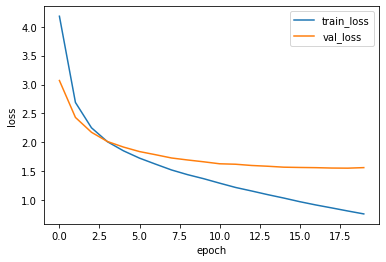

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

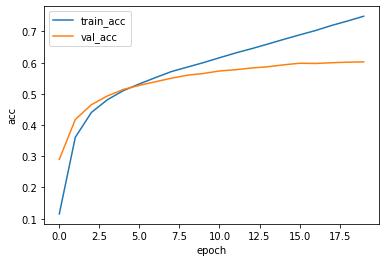

In [ ]:
plt.plot(acc_plot, label='train_acc')
plt.plot(val_acc_plot, label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

## 추론

In [ ]:
def evaluate(tokens):
    transformer.to(device)
    decoder_input = torch.tensor([tar_tokenizer.txt2idx['sos_']] * tokens.size(0), dtype=torch.long).to(device)
    output = decoder_input.unsqueeze(1).to(device)
    enc_output = None
    for i in range(decoder_len-1):        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        with torch.no_grad():
            predictions, attention_weights, enc_output = transformer([tokens, output, enc_output])
        
        # select the last token from the seq_len dimension
        predictions_ = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        
        predicted_id = torch.tensor(torch.argmax(predictions_, axis=-1), dtype=torch.int32)
        
        output = torch.cat([output, predicted_id], dim=-1)
    output = output.cpu().numpy()
    
    summary_list = []
    token_list = []
    for token in output:
        summary = tar_tokenizer.convert(token)
        summary_list.append(summary)
        token_list.append(token)
    return summary_list, token_list

In [ ]:
tqdm_dataset = tqdm(enumerate(val_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['src_token'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

29it [02:57,  6.11s/it]


In [ ]:
for i, (a, p) in enumerate(zip(df_val.summary, preds)):
    print('정답 :', a)
    print('예측 :', p)
    print('=================================================================================')
    if i == 10:
        break

정답 : 소상공인 경영환경 개선사업의 경우 지속적으로 사업을 더 늘려서 많은 업소가 혜택을 볼 수 있도록 할 것. 신재생에너지 보급확대 사업에도 소상공인 혜택이 빠지지 않도록 할 것.
예측 :  수도 사업소 소관 2018 년도 행정 사무 감사 시정 , 건의사항 조치 결과 보고.
정답 : 제155회 완주군의회 임시회 회기는 10월 27일부터 11월 3일까지 8일간으로 가결됨.
예측 :  제 완주군 의회 회 완주군 의회 임시회 회기는 11 월 10 일부터 11 월 11 일까지 3 일 간으로 가결됨.
정답 : 2001년도 제1회 추가경정 세입세출예산안 제안 설명의 건.
예측 :  2005 년도 세입 세출 예산안 제안 설명 . 해당 안건은 가결됨.
정답 : 2013년 중기지방재정계획 보고.
예측 :  2012 년도 행정 사무 감사 시정 및 건의사항 조치 결과 보고.
정답 : 제124회 완주군의회 임시회 제1차 본회의 개의 선포.
예측 :  완주군 의회 행정 사무 감사 특별 위원회 위원으로 송지용 의원 , 박웅배 의원 , 박종관 의원 , 홍의환 의원 , 홍의환 의원 , 임원규 의원 , 임원규 의원 , 임원규 의원 , 임원규 의원 , 임원규 의원 , 임원규 의원이 선임됨.
정답 : 공유재산 관리계획 변경계획안 제안설명.
예측 :  2016 년도 공유 재산 관리 계획안은 음성군 공유 재산 관리 계획을 받고자 음성군 공유 재산 심의회의의결을 받고자 제안됨. 해당 안건은 가결됨.
정답 : 제134회 음성군의회 임시회 회기는 10월 7일부터 10월 9일까지 3일간으로 가결됨.
예측 :  음성군 의회 회의 규칙 일부 개정 규칙 안은 음성군 의회 회의 회기는 10 월 23 일부터 10 월 26 일까지 7 일 간으로 가결됨.
정답 : 음성군 지방공무원 정원 조례 중 개정조례안은 보건복지부의 기초생활보호대상 배치기준에 의거 2명의 사회복지직 정원이 승인되었기에 증원하여 복지행정 서비스 수준의 형평을 유지하고자 발의함. 해당 안건은 가결됨. 음성군 리장 정원 조례 중 개정조례안과 반 설

## 제출

In [ ]:
tqdm_dataset = tqdm(enumerate(test_dataloader))
preds = []
tokens = []
for batch, batch_item in tqdm_dataset:
    output = evaluate(batch_item['src_token'].to(device))
    preds.extend(output[0])
    tokens.extend(output[1])

16it [01:39,  6.22s/it]


In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['summary'] = preds

In [ ]:
submission.head()

,uid,summary
0,id_2000-AGENDA_1,음성군 의회 제 1 차 정례회 제 1 차 본회의개의선포 . 운영 위원회 위원으로 ...
1,id_2000-AGENDA_2,음성군 의회 정례회의운영에 관한 조례 안은 음성군의회기는 6 월 23 일부터 6 ...
2,id_2000-AGENDA_3,"회의록 서명 의원으로 한동완 의원 , 이대웅 의원이 선출됨."
3,id_2000-AGENDA_4,"예산 결산 특별 위원회 위원으로 이한철 의원 , 반광홍 의원 , 정태완 의원 , ..."
4,id_2000-AGENDA_5,음성군 의회 운영 조례 안은 음성군 의회 운영의효율 적인 활동을 위해 주요 시설을...


In [ ]:
submission.to_csv('dacon_baseline.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
submission.to_csv("/content/drive/My Drive/dacon_baseline_submission_1014.csv")

제출 API 사용법 => https://dacon.io/forum/403557

In [ ]:
# from dacon_submit_api import dacon_submit_api 

# result = dacon_submit_api.post_submission_file(
#     'dacon_baseline.csv', 
#     '개인 Token', 
#     '235813',
#     'BASELINE', 
#     'DACON_Baseline'
# )